In [325]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Nx = 128

ncc_cutoff = 1e-3
tolerance = 1e-14
dealias = 3/2
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.Chebyshev(coords['x'], size= Nx, bounds=(0, 1))
xbasis2 = xbasis.derivative_basis(2)
# Fields
u = dist.Field(name='u', bases=(xbasis,))
f = dist.Field(name='f', bases=(xbasis2,))
tau_u1 = dist.Field(name='tau_u1')
tau_u2 = dist.Field(name='tau_u2')

lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
dx = lambda A: d3.Differentiate(A,coords['x'])

# Substitutions
lift = lambda A,n: d3.Lift(A, lift_basis, n)
nu = 0.1
u_x = dx(u) + lift(tau_u1,-1)
# Problem
problem = d3.NLBVP([u,tau_u1,tau_u2], namespace=locals())
problem.add_equation("0.5*u*u_x - nu*dx(u_x) + lift(tau_u2,-1) = f")
problem.add_equation("u(x=0) = 0")
problem.add_equation("u(x=1) = 0")

In [326]:
pert_norm = np.inf
x, = dist.local_grids(xbasis)

f['g'] = np.sin(x*np.pi*2) 
u['g'] = np.sin(x*np.pi*2)

# # Solver
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)

while pert_norm > tolerance:
    solver.newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')

2023-04-30 12:06:31,732 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s
2023-04-30 12:06:31,735 __main__ 0/1 INFO :: Perturbation norm: 8.011e-01
2023-04-30 12:06:31,893 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+00/s
2023-04-30 12:06:31,895 __main__ 0/1 INFO :: Perturbation norm: 6.370e-02
2023-04-30 12:06:31,922 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-04-30 12:06:31,924 __main__ 0/1 INFO :: Perturbation norm: 3.363e-04
2023-04-30 12:06:31,952 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
2023-04-30 12:06:31,954 __main__ 0/1 INFO :: Perturbation norm: 1.327e-07
2023-04-30 12:06:31,981 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+01/s
2023-04-30 12:06:31,983 __main__ 0/1 INFO ::

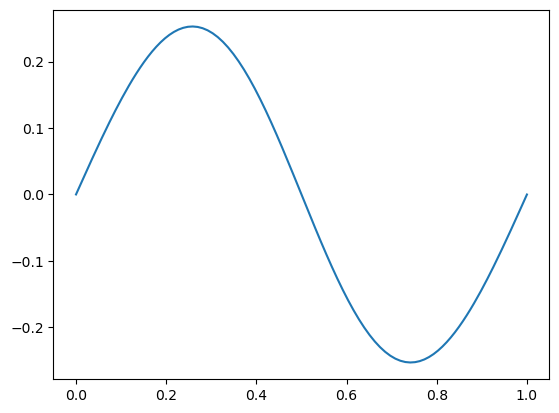

In [327]:
plt.plot(x,u['g'])
uTrue = u.copy()

In [328]:
print(solver.F[0])

C(0.5*u*(dx(u) + <Field 5211618272>*tau_u1)) + C(-1*0.1*dx(dx(u) + <Field 5211618272>*tau_u1)) + C(<Field 5211618272>*tau_u2) + C(-1*f)


In [329]:
from dedalus.tools import jacobi
# Get spectrally accurate weight matrices
a, b = xbasis.a, xbasis.b
integ_vector = jacobi.integration_vector(Nx, a, b)

W_field = u.copy_adjoint()

for i in range(Nx):
    W_field['c'][i] = 0.5*integ_vector[i]


In [330]:
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)

In [361]:
def directAdjointLoopGrid(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    f['g'] = forcing[:Nx]
    
    u['g'] = np.sin(2*np.pi*x)  
    tau_u1['g']=0
    tau_u2['g']=0
    
    pert_norm = np.inf

    while pert_norm > tolerance:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        
    # Check
    cost = 0.5*d3.integ(np.conj(u-uTrue)*(u-uTrue)).evaluate()['g'][0]
    
    solver.state_adj[0]['g'] = W_field['g']*(u['g']-uTrue['g'])
    
    solver.solve_adjoint()
    
    return cost, -solver.F_adj[0]['g']

In [362]:
pert_norm = np.inf
x, = dist.local_grids(xbasis)

# f['g'] = x*(1-x)
f['g'] = np.sin(4*np.pi*x)
u['g'] = np.sin(x*np.pi*2)
tau_u1['g']=0
tau_u2['g']=0
# # Solver
solver = problem.build_solver(ncc_cutoff=ncc_cutoff)

while pert_norm > tolerance:
    solver.newton_iteration()
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
u0 = u.copy()

2023-04-30 12:08:33,970 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2023-04-30 12:08:33,972 __main__ 0/1 INFO :: Perturbation norm: 1.031e+00
2023-04-30 12:08:34,007 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-04-30 12:08:34,008 __main__ 0/1 INFO :: Perturbation norm: 1.226e-01
2023-04-30 12:08:34,042 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-04-30 12:08:34,044 __main__ 0/1 INFO :: Perturbation norm: 1.717e-03
2023-04-30 12:08:34,076 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2023-04-30 12:08:34,078 __main__ 0/1 INFO :: Perturbation norm: 3.950e-07
2023-04-30 12:08:34,105 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-04-30 12:08:34,107 __main__ 0/1 INFO ::

In [363]:
from scipy import optimize

opts = {'disp': True}
forcing = np.sin(4*np.pi*x)

sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True,options=opts,tol=1e-8)

2023-04-30 12:08:35,104 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
2023-04-30 12:08:35,106 __main__ 0/1 INFO :: Perturbation norm: 1.031e+00
2023-04-30 12:08:35,141 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s
2023-04-30 12:08:35,143 __main__ 0/1 INFO :: Perturbation norm: 1.226e-01
2023-04-30 12:08:35,178 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2023-04-30 12:08:35,180 __main__ 0/1 INFO :: Perturbation norm: 1.717e-03
2023-04-30 12:08:35,207 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-04-30 12:08:35,209 __main__ 0/1 INFO :: Perturbation norm: 3.950e-07
2023-04-30 12:08:35,241 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2023-04-30 12:08:35,242 __main__ 0/1 INFO ::

 This problem is unconstrained.


2023-04-30 12:08:35,503 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2023-04-30 12:08:35,505 __main__ 0/1 INFO :: Perturbation norm: 7.825e-01
2023-04-30 12:08:35,537 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-04-30 12:08:35,539 __main__ 0/1 INFO :: Perturbation norm: 6.717e-02
2023-04-30 12:08:35,566 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+01/s
2023-04-30 12:08:35,568 __main__ 0/1 INFO :: Perturbation norm: 4.943e-04
2023-04-30 12:08:35,594 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-04-30 12:08:35,596 __main__ 0/1 INFO :: Perturbation norm: 1.334e-07
2023-04-30 12:08:35,622 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2023-04-30 12:08:35,623 __main__ 0/1 INFO ::

2023-04-30 12:08:36,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2023-04-30 12:08:36,628 __main__ 0/1 INFO :: Perturbation norm: 3.724e-04
2023-04-30 12:08:36,654 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+01/s
2023-04-30 12:08:36,655 __main__ 0/1 INFO :: Perturbation norm: 8.477e-07
2023-04-30 12:08:36,681 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-04-30 12:08:36,683 __main__ 0/1 INFO :: Perturbation norm: 6.525e-10
2023-04-30 12:08:36,708 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+01/s
2023-04-30 12:08:36,710 __main__ 0/1 INFO :: Perturbation norm: 1.364e-12
2023-04-30 12:08:36,736 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-04-30 12:08:36,738 __main__ 0/1 INFO ::

2023-04-30 12:08:37,816 __main__ 0/1 INFO :: Perturbation norm: 8.015e-01
2023-04-30 12:08:37,845 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s
2023-04-30 12:08:37,848 __main__ 0/1 INFO :: Perturbation norm: 6.401e-02
2023-04-30 12:08:37,874 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-04-30 12:08:37,876 __main__ 0/1 INFO :: Perturbation norm: 3.432e-04
2023-04-30 12:08:37,902 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s
2023-04-30 12:08:37,904 __main__ 0/1 INFO :: Perturbation norm: 1.190e-07
2023-04-30 12:08:37,931 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+01/s
2023-04-30 12:08:37,932 __main__ 0/1 INFO :: Perturbation norm: 2.298e-11
2023-04-30 12:08:37,957 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, R

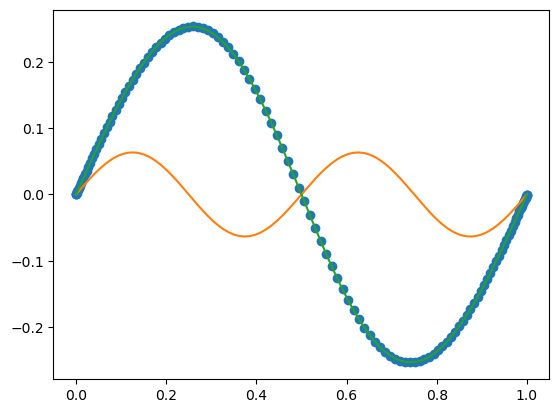

In [364]:
plt.plot(x,u['g'],'o')
plt.plot(x,u0['g'])
plt.plot(x,uTrue['g'])

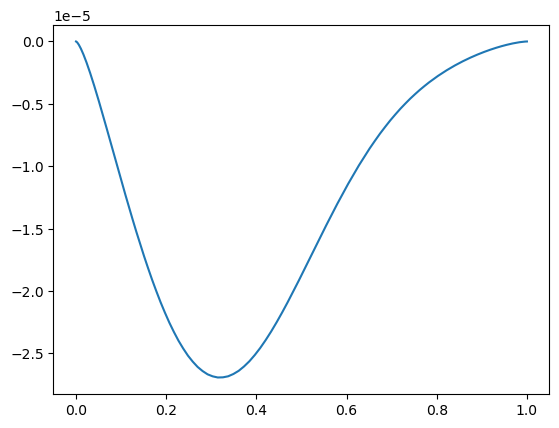

In [350]:
plt.plot(x,solver.F_adj[0]['g'])

In [351]:
print(solver.F[0].domain.bases[0])

Jacobi(x, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)


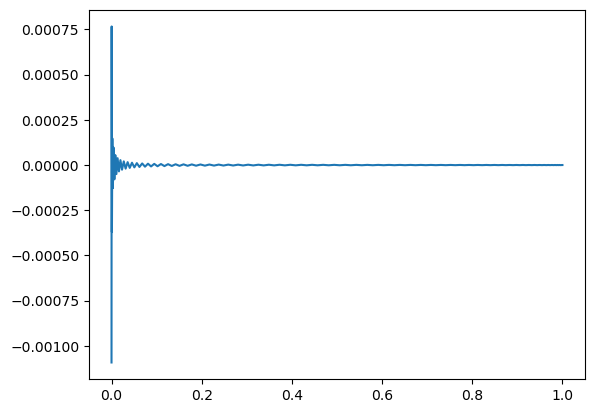

In [352]:
plt.plot(x,solver.F_adj[0]['c'])

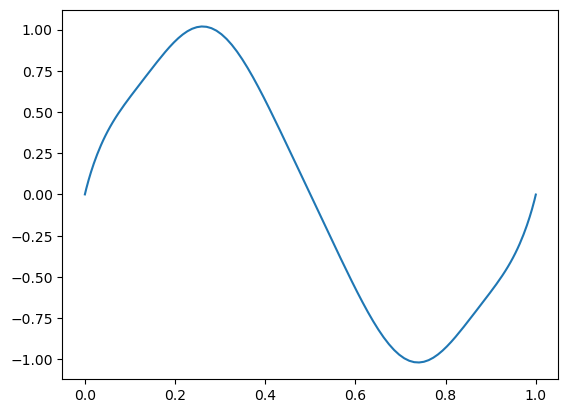

In [365]:
plt.plot(x,f['g'])

In [366]:
# Try the Taylor test

In [367]:
forcing0 = np.sin(4*np.pi*x)
forcing1 = np.sin(6*np.pi*x)
cost0,grad0 = directAdjointLoopGrid(forcing0)
eps=0.001
costs = []
terms = []
epss = []
for i in range(10):
    epss.append(eps)
    costp,gradp = directAdjointLoopGrid(forcing0+eps*forcing1) 
    costs.append(costp)
    terms.append((costp-cost0)/eps)
    eps /=2

adj = np.vdot(grad0,forcing1)



2023-04-30 12:08:42,470 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2023-04-30 12:08:42,473 __main__ 0/1 INFO :: Perturbation norm: 1.031e+00
2023-04-30 12:08:42,511 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-04-30 12:08:42,513 __main__ 0/1 INFO :: Perturbation norm: 1.226e-01
2023-04-30 12:08:42,542 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
2023-04-30 12:08:42,543 __main__ 0/1 INFO :: Perturbation norm: 1.717e-03
2023-04-30 12:08:42,573 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+01/s
2023-04-30 12:08:42,574 __main__ 0/1 INFO :: Perturbation norm: 3.950e-07
2023-04-30 12:08:42,601 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-04-30 12:08:42,603 __main__ 0/1 INFO ::

2023-04-30 12:08:43,711 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s
2023-04-30 12:08:43,714 __main__ 0/1 INFO :: Perturbation norm: 6.906e-11
2023-04-30 12:08:43,742 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-04-30 12:08:43,744 __main__ 0/1 INFO :: Perturbation norm: 1.068e-15
2023-04-30 12:08:43,771 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+01/s
2023-04-30 12:08:43,772 __main__ 0/1 INFO :: Perturbation norm: 1.031e+00
2023-04-30 12:08:43,800 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+01/s
2023-04-30 12:08:43,802 __main__ 0/1 INFO :: Perturbation norm: 1.226e-01
2023-04-30 12:08:43,828 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2023-04-30 12:08:43,830 __main__ 0/1 INFO ::

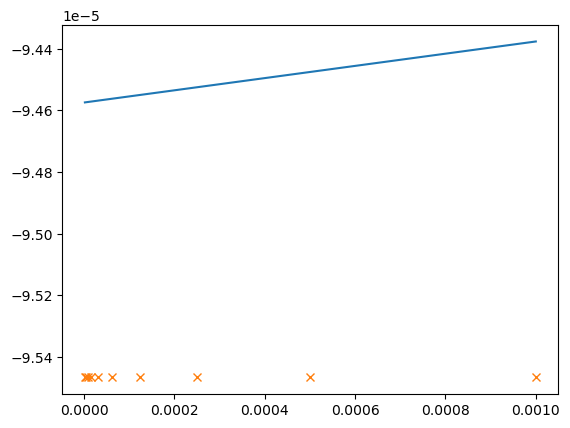

In [368]:
plt.plot(epss,terms)
plt.plot(epss,adj*np.ones(10),'x')

In [369]:
first_order  = np.abs(np.array(costs)-cost0)
second_order = np.abs(np.array(costs)-cost0-np.array(epss)*adj)

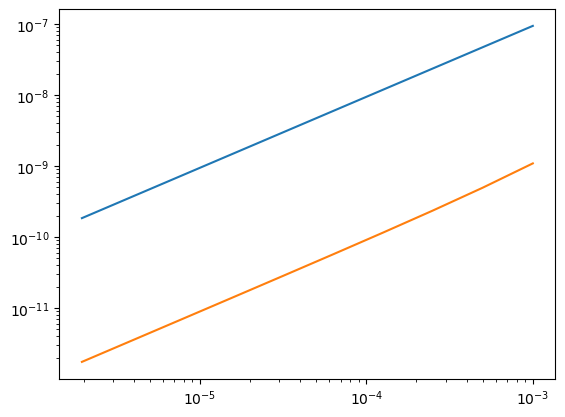

In [370]:
plt.loglog(epss,first_order)
plt.loglog(epss,second_order)

In [371]:
from scipy.stats import linregress
print('######## Taylor Test Results ########')
print('First order  : ',linregress(np.log(epss), np.log(first_order)).slope)
print('Second order : ',linregress(np.log(epss), np.log(second_order)).slope)
print('#####################################')

######## Taylor Test Results ########
First order  :  0.9997428145810074
Second order :  1.0251062964905047
#####################################


In [372]:
print(terms[-1])
print(adj)

-9.457389893441359e-05
-9.54669297556447e-05
